In [1]:
# UOC
# Grado de Ingeniería Informática
# Inteligencia Artificial
# TFG - Aplicación de Técnicas de Explicabilidad (XAI) y Cuantificación de Incertidumbre (UQ) en la Predicción del Síndrome Metabólico mediante Aprendizaje Automático
# Xema Belmonte Marín

# Explicabilidad del modelo (XAI)

Hemos encontrado un modelo satisfactorio al que vamos a aplicarle técnicas de explicabilidad *post hoc* y descubrir que características de los datos han sido determinantes para sus resultados. Algunos de los métodos que se emplearán en este cuaderno serán globales y otros locales, pero todos son *model-agnostic*, es decir, independientes del tipo de modelo. Como métodos globales se han realizado la *permutation feature importance* y los *Partial Dependence Plot* (PDP); como locales, *Individual Conditional Expectation* (ICE), LIME (*Local Interpretable Model-agnostic Explanations*), DiCE (*Diverse Counterfactual Explanations*) y SHAP (Shapley Additive Explanations).

## Librerías y funciones

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn: exploración de los datos
from sklearn.metrics import mutual_info_score, roc_auc_score

# Scikit-learn: modelo de aprendizaje automático
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn:: evaluación
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import FixedThresholdClassifier

# Scikit-learn:: interpretación del modelo
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# XAI: interpretación del modelo
import shap
from lime import lime_tabular
import dice_ml as dice

%matplotlib inline

### Funciones

In [3]:
# Opciones generales

# Desactivar warnings
warnings.filterwarnings("ignore")

# Mostramos dos decimales
pd.options.display.float_format = '{:,.2f}'.format

# Tamaño de letra en los gráficos
font = {'size': 12}
plt.rc('font', **font)

In [4]:
def local_prediction(observation):
    """
    Imprime la observación pasada, las predicciones del modelo y la ground truth
    """
    # Seleccionamos una muestra y su clasificación
    display(X_test.iloc[[observation]].style.hide(axis="index"))

    pred_prob = model.predict_proba(X_test.iloc[[observation]]).round(2)
    pred = model_t.predict(X_test.iloc[[observation]])

    print(f"Raw score: {pred_prob[0]}")
    print(f"Predicción síndrome metabólico del modelo con umbral {threshold}: {pred[0]} ({pred_prob[0][1]:.2f})")
    print(f"Diagnóstico real: {y_test.iloc[observation][0]}")

## Aplicación del modelo seleccionado

El modelo seleccionado es un bosque aleatorio, un caso particular de *bagging ensemble*, elegido por su capacidad para minimizar los Falsos Negativos en la tarea de clasificación binaria para la predicción del diagnóstico de síndrome metabólico. A continuación, cargamos los conjuntos preprocesados de entrenamiento y prueba, para luego alimentar al modelo:

In [5]:
# Cargamos los conjuntos de datos preprocesados
X_train = pd.read_csv('metabolic_syndrome_x_train.csv')
y_train = pd.read_csv('metabolic_syndrome_y_train.csv')
X_test = pd.read_csv('metabolic_syndrome_x_test.csv')
y_test = pd.read_csv('metabolic_syndrome_y_test.csv')

In [6]:
# Modelo seleccionado
model = RandomForestClassifier(
    n_estimators=300,
    criterion='entropy',
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=5,
    max_features=None,
    random_state=23,
)
threshold = 0.202

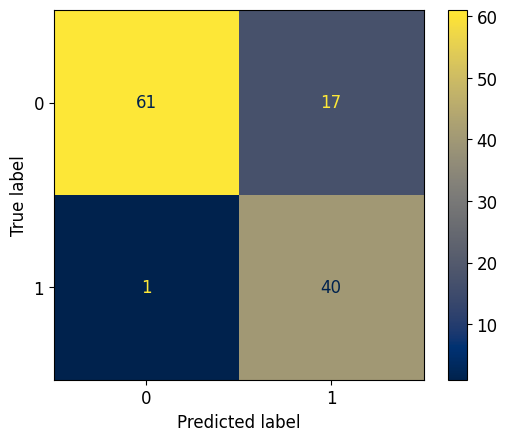

In [7]:
# Entrenamos el modelo y mostramos la matriz de confusión con las predicciones sobre el conjunto de prueba
model.fit(X_train, y_train)
ConfusionMatrixDisplay.from_predictions(y_test, model.predict_proba(X_test)[:,1] >= threshold, cmap = 'cividis')
# Modelo con umbral
model_t = FixedThresholdClassifier(model, threshold=threshold, response_method="predict_proba").fit(X_train, y_train)

El bosque aleatorio, como caso de modelo de *ensemble*, no es interpretable y entra en la categoría de opaco (*black box model*). Por este motivo, requiere el uso de técnicas de explicabilidad *post hoc*, es decir, aquellas que se aplican una vez que el modelo ha sido entrenado y ha generado sus predicciones. Estas técnicas que aplicaremos son *model-agnostic*, lo que significa que no dependen de un tipo específico de algoritmo de aprendizaje automático y pueden utilizarse con cualquier modelo que proporcione predicciones. En este sentido, exploraremos estos métodos diferenciándolos en dos categorías principales: los locales, que explican predicciones individuales, y los globales, que ofrecen una visión más amplia del comportamiento general del modelo. Esta distinción permitirá comprender tanto decisiones específicas como patrones generales en las predicciones del modelo.

## Global Model-Agnostic Methods

### Permutation Feature Importance

El concepto de *feature importance* trata de responder una pregunta básica sobre los modelos: ¿Qué características tienen el mayor impacto en las predicciones?

Los modelos basados en árboles de Scikit-learn incluyen el atributo `feature_importances_` para inspeccionar cómo las variables de un conjunto de datos afectan globalmente al modelo. *Random forest* devuelve una puntuación para cada atributo que nos indica lo importante que ha sido en la construcción de los árboles que se han ido agregando al modelo. Accedamos a esa información:

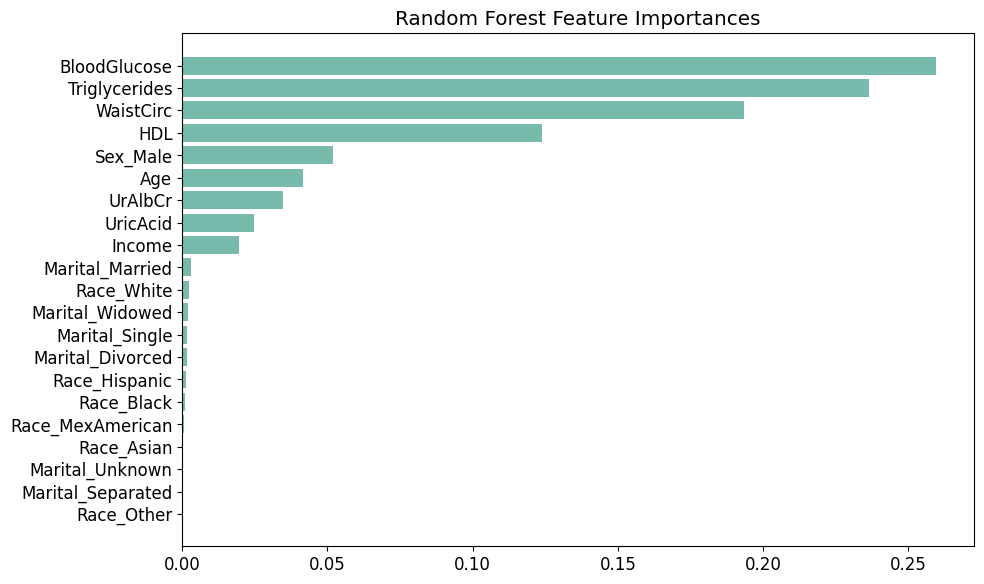

In [8]:
# Obtenemos las feature importances para el modelo Random Forest
sorted_indices_rf = model.feature_importances_.argsort()
feature_names = X_test.columns

# Visualizamos con los atributos ordenados de mayor a menor importancia
plt.figure(figsize=(10, 6))

plt.barh(range(len(feature_names)), model.feature_importances_[sorted_indices_rf], color='#69B3A2', alpha=0.9)
plt.yticks(range(len(feature_names)), feature_names[sorted_indices_rf])
plt.title("Random Forest Feature Importances")

plt.tight_layout()
plt.show()

El problema de esta función integrada, como las [análogas en otros métodos de *ensemble*](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27), aunque rápida, es que no siempre ofrece una imagen consistente de la importancia. La *feature importance* del bosque aleatorio se basa en la medida de impureza, como esta disminuye con cada árbol, y puede confundir si las características tienen muchos valores únicos (alta cardinalidad). Además, se calculan sobre las estadísticas del conjunto de entrenamiento y, por lo tanto, no reflejan la utilidad de la característica para hacer predicciones generalizadas al conjunto de prueba.

La técnica de *permutation feature importance* es aplicable a cualquier modelo y es razonablemente eficiente y confiable. Mide directamente la importancia de las características observando el efecto en la precisión del modelo al mezclar aleatoriamente cada variable predictora, no dependiendo de parámetros internos del modelo (como serían la impureza, pesos o coeficientes de regresión). Para su cálculo se requiere únicamente el conjunto de prueba.

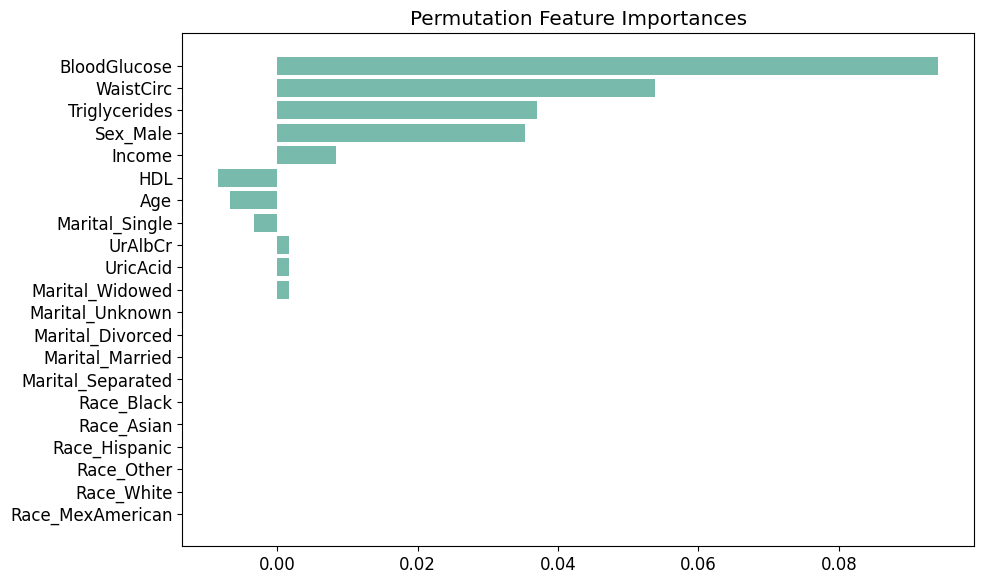

In [9]:
# Obtenemos la importancia de las características usando permutation feature importance
importance_perm = permutation_importance(model, X_test, y_test, random_state=23)

# Tenemos en cuenta valores negativos para la ordenación
sorted_indices_perm = np.argsort(np.abs(importance_perm.importances_mean))

# Visualizamos con los atributos ordenados de mayor a menor importancia
plt.figure(figsize=(10, 6))

plt.barh(range(len(feature_names)), importance_perm.importances_mean[sorted_indices_perm], color='#69B3A2', alpha=0.9)
plt.yticks(range(len(feature_names)), feature_names[sorted_indices_perm])
plt.title("Permutation Feature Importances")

plt.tight_layout()
plt.show()

Los resultados son consistentes en las características más relevantes para este *random forest*: `BloodGlucose`, `Triglycerides`, `WaistCirc` o `HDL`, que se corresponden con las predictoras que ya habíamos identificado en el cuaderno de exploración. También pudimos constatar una tendencia en la edad, que tenía cierta relación con el estado civil 'Single'. Las personas más jovenes acostumbran a estar solteras y la prevalencia de síndrome metabólico es ligeramente mayor en población más adulta. Sin embargo, no se pudo constatar ninguna correspondencia con los ingresos, tal como el modelo atestigua.

En nuestro caso, los dos métodos son consistentes, debido seguramente a la falta de correlación entre las variables y/o alta cardinalidad de éstas, pero se puede apreciar como en el conjunto de entrenamiento muchas de las variables que definen el estado civil (`Marital_`) y la población étnica (`Race_`) no tienen importancia nula, tal como la tienen con el *set* de prueba.

In [10]:
# Comparamos permutation feature importance para el set de entrenamiento y prueba
importance_perm_train = permutation_importance(model, X_train, y_train, random_state=23)
importance_perm_test = permutation_importance(model, X_test, y_test, random_state=23)

sorted_importances_idx = importance_perm_train.importances_mean.argsort()

train_importances = pd.DataFrame(
    importance_perm_train.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    importance_perm_test.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)

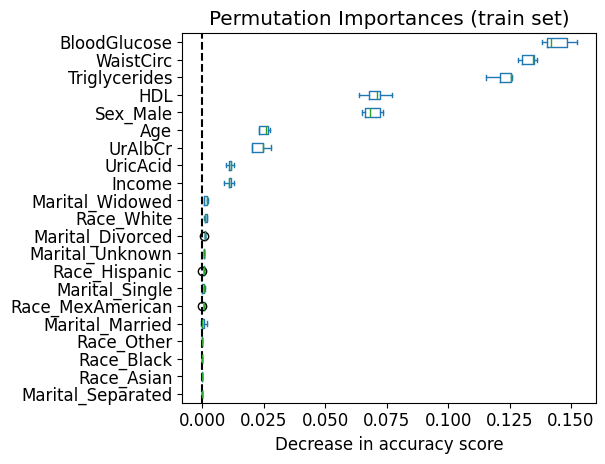

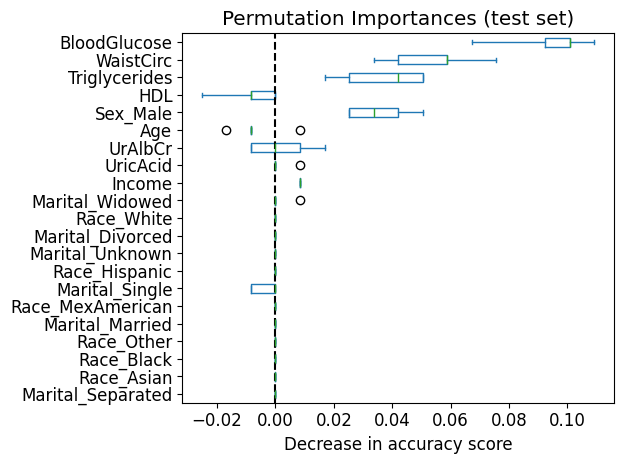

In [11]:
# Visualizamos
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

En definitiva, aunque las importancias relativas varíen, las mismas características se detectan como las más importantes utilizando ambos métodos. Sin embargo, *feature importance* cuantifica la contribución de una característica específica al poder predictivo del modelo, devolviendo un solo número y descuidando la identificación de comportamientos heterogéneos en los datos. Podría darse el caso de que una característica de poca importancia produzca mucha variación en las predicciones, pero que ésta fuera moderada. La *permutation feature importance* se vuelve menos reveladora en estos casos. Podemos eludir esta limitación con los gráficos de dependencia parcial (PDP) y los de expectativa condicional individual (ICE), que permiten visualizar las relaciones no lineales o interacciones específicas entre variables y las predicciones del modelo.

### Partial Dependence Plot (PDP)

Los PDP muestran la dependencia que tiene la variable objetivo con respecto a un conjunto de características de interés que se proporcionan como entrada. Los valores del resto de predictoras se marginan y queda visualizado únicamente el efecto medio de las variaciones de los atributos seleccionados sobre el *raw score* de la predicción. Para poder interpretar estos gráficos dentro de los límites de la percepción humana, el tamaño del conjunto de características de interés constará de, a lo sumo, una o dos variables. Visualicemos prácticamente todas las variables en un gráfico conjunto de PDPs de *1-way* (considerando una característica a la vez):

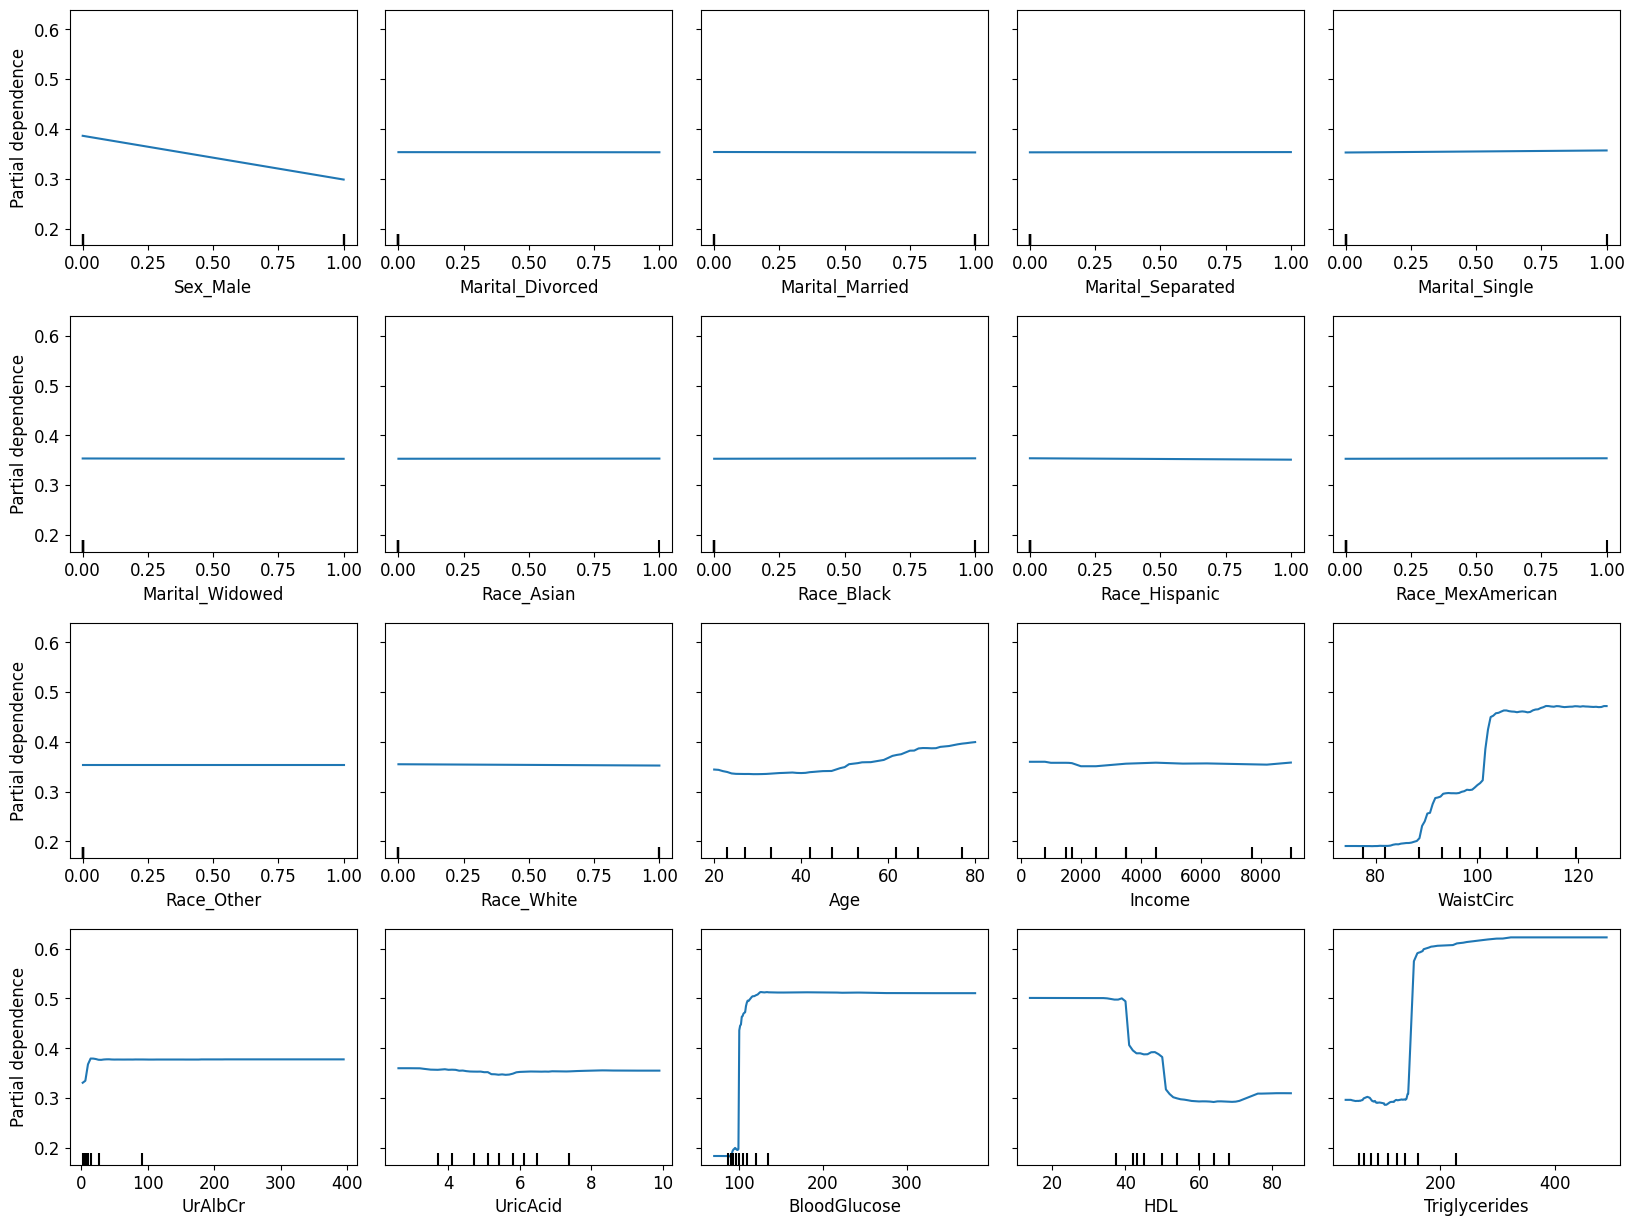

In [12]:
# Para 20 variables
feature_names = [col for col in X_test.columns if col != 'Marital_Unknown']

# Subplots en 4 filas de 5 plots
fig, axes = plt.subplots(4, 5, figsize=(20, 15))

# Generamos los PDPs para cada feature
pdp = PartialDependenceDisplay.from_estimator(model, X_test, features=feature_names, random_state=23, ax=axes)

pdp.figure_.subplots_adjust(hspace=0.3, wspace=0.1)

Los ejes de las X representan el rango de valores de la característica que se analiza y los de las Y el resultado promedio de la predicción del modelo para el valor de la variable. La línea de dependencia parcial que se forma es la vista agregada de cómo el cambio de la variable afecta las predicciones del modelo. Aquellas líneas planas sin pendiente, que no producen variaciones en los resultados de la clasificación, corresponden a características que no son relevantes. A excepción de `Sex_Male`, el resto de variables categóricas no parecen tener apenas influencia en el modelo, como hemos corroborado con las *feature importances*. En ese apartado vimos que las características que debemos considerar son `BloodGlucose`, `Triglycerides` y `WaistCirc`, que muestran como valores más altos están relacionados con el diagnóstico de síndrome metabólico, así como `HDL`, en sentido inverso.

Podemos ahora crear *2-way* PDPs con combinaciones de dos de esas características:

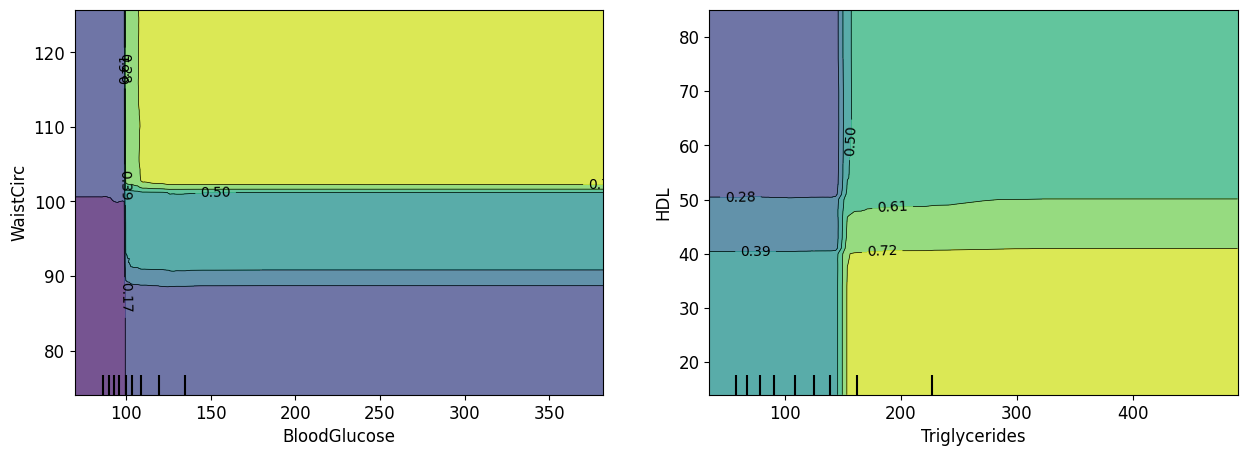

In [13]:
# Para las combinaciones de azúcar con obesidad central y triglicéridos con colesterol
features = [('BloodGlucose', 'WaistCirc'), ('Triglycerides', 'HDL')]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

PartialDependenceDisplay.from_estimator(model, X_test, features=features, kind='average', random_state=23, ax = axes)

Ahora podemos visualizar las interacciones de dos características a la vez. El PDP de la izquierda muestra la dependencia del diagnóstico de síndrome metabólico de los valores conjuntos del azúcar en sangre y la circunferencia de la cintura. Con unos niveles de glucosa superiores a 110 mg/dL, la obesidad central tiene un fuerte impacto en el diagnóstico positivo, con el máximo aumento en la puntuación para más de 100 cm. En la derecha observamos la arriesgada combinación de triglicéridos altos con un HDL bajo. Algo que ya habíamos detectado en el cuaderno de exploración, prácticamente garantizando síndrome metabólico cuando este ratio es alto.

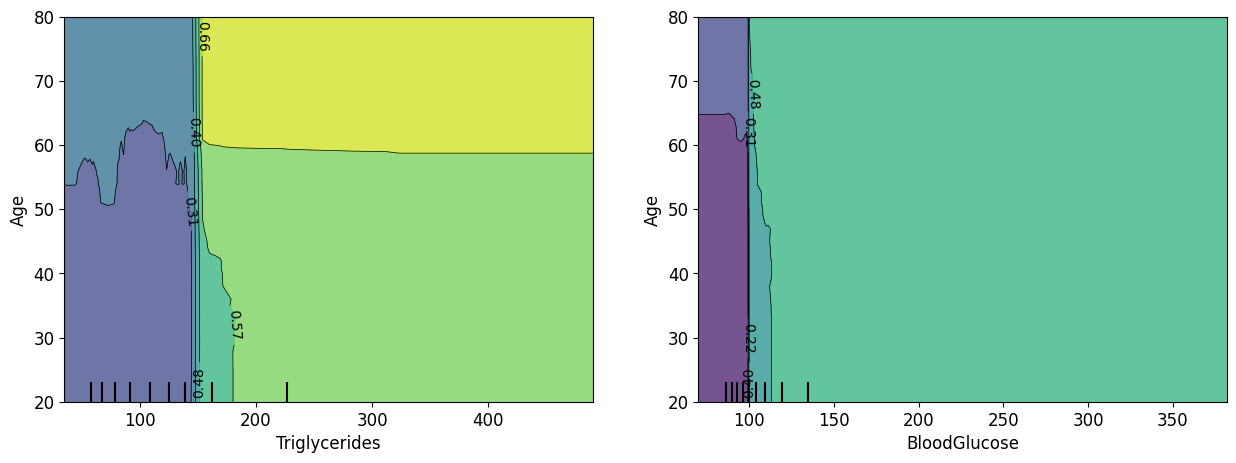

In [14]:
# Para las combinaciones de azúcar con obesidad central y triglicéridos con colesterol
features = [('Triglycerides', 'Age'), ('BloodGlucose', 'Age')]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

PartialDependenceDisplay.from_estimator(model, X_test, features=features, kind='average', random_state=23, ax = axes)

Sirvan estos dos últimos PDPs para observar como la edad no es un factor siempre que se mantengan niveles bajos de triglicéridos y glucosa en sangre. El *partial dependence plot* es un método global porque no se centra en observaciones específicas, sino en el efecto promedio de una característica. El equivalente a un PDP para predicciones individuales se denomina *Individual Conditional Expectation (ICE) Plot* y lo mostraremos a continuación.

## Local Model-Agnostic Methods

### Individual Conditional Expectation (ICE)

Un ICE *plot* visualiza la dependencia de la predicción de una característica para cada observación por separado, lo que da como resultado una línea por instancia. Muestra cómo cambia la predicción del modelo para los diferentes valores de una variable, pero en comparación con el PDP que muestra el efecto promedio, lo hace, en nuestro caso, por cada persona. Un PDP es por tanto el promedio de las líneas de un gráfico ICE.

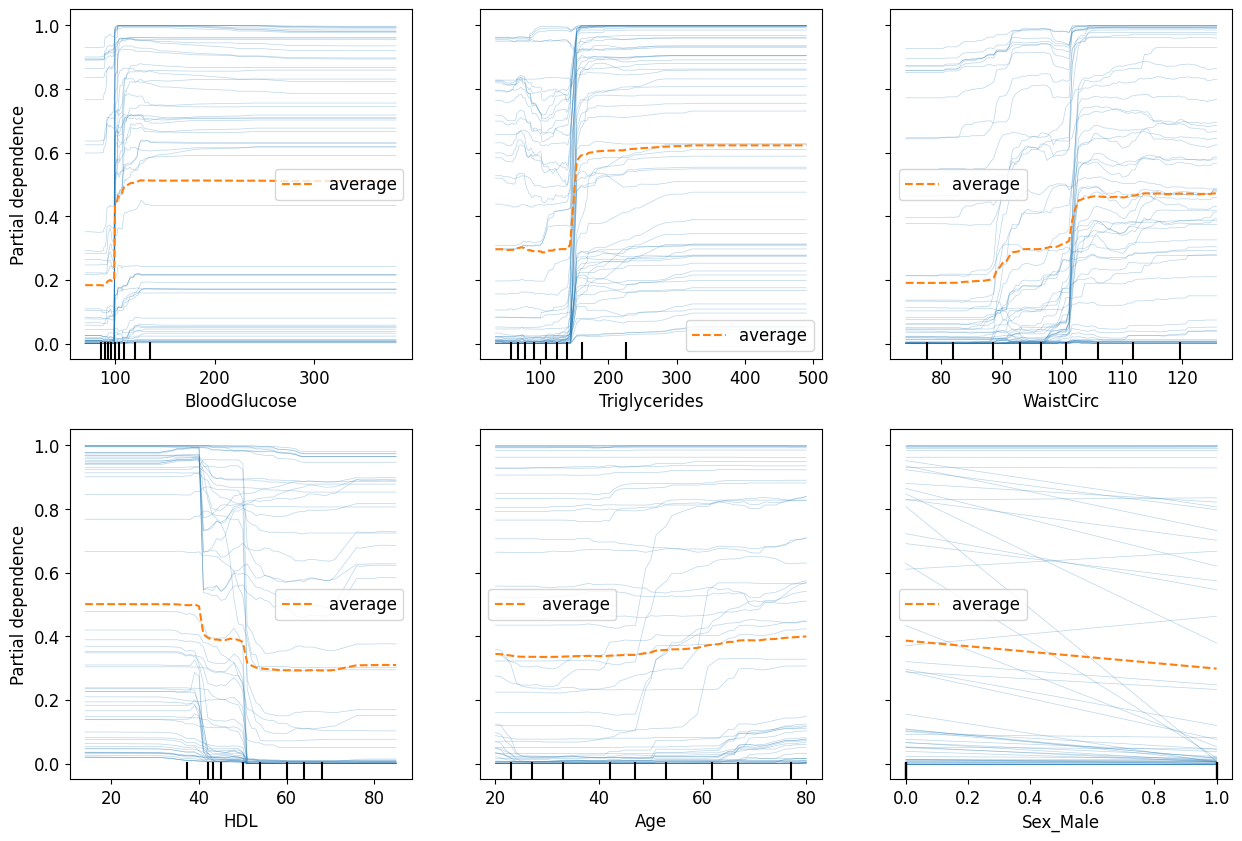

In [15]:
# PDP y ICE para las características más importantes
features = ['BloodGlucose', 'Triglycerides', 'WaistCirc', 'HDL', 'Age', 'Sex_Male']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

PartialDependenceDisplay.from_estimator(model, X_test, features=features, kind='both', subsample=0.5, random_state=23, ax=axes)

En general, las curvas parecen seguir una misma tendencia, lo que significa que el PDP ya es un buen resumen de las relaciones entre las características mostradas y el diagnóstico de síndrome metabólico. Esto es muy evidente, por ejemplo, para `BloodGlucose` y `Triglycerides`, aunque para `HDL`hay ciertas interacciones no tan monotónicas. Con los PDP pudimos intuir mejor su relación con los triglicéridos, pero los gráficos ICE solo admiten una característica debido a los "límites de la percepción humana". Para `Age` sí que se observa cierta información adicional: entre las líneas planas aparecen algunas que muestran un aumento significativo en la dependencia una vez superados los 45 años, mientras que otras lo hacen al llegar a los 60.

Vayamos ahora a la raíz de las técnicas locales y analicemos el comportamiento del modelo para una predicción en concreto. Con métodos como LIME y SHAP podemos entender que atributos han sido los que más han contribuído en la construcción de cada puntuación individual.

## LIME (Local Interpretable Model-agnostic Explanations)

LIME nos permite explicar predicciones individuales en un modelo opaco, es decir, realizar una interpretación local en lugar de una interpretación global. Para una determinada observación, LIME indica qué variables consideró el modelo más importantes para llevar a cabo su predicción. Lo hace "perturbando" la muestra en cuestión y la aproxima con un modelo interpretrable, lo que se conoce como un modelo local subrogado. Apliquemos LIME a la última fila:

In [16]:
local_prediction(-1)

Raw score: [0.4 0.6]
Predicción síndrome metabólico del modelo con umbral 0.202: 1 (0.60)
Diagnóstico real: 1


In [17]:
# Creamos el explainer para LIME, convirtiendo con .values los DataFrames a numpy arrays
explainer = lime_tabular.LimeTabularExplainer(
                    X_train.values,
                    mode='classification',
                    feature_names=X_train.columns,
                    class_names=['MS=0','MS=1'],
                    discretize_continuous=True,
                    random_state=23)

# Obtenemos y mostramos la explicación para la última observación
explanation = explainer.explain_instance(
                    X_test.iloc[-1].values,
                    model.predict_proba)
explanation.show_in_notebook(show_table=True, show_all=False)

La tabla de la derecha muestra solo las variables utilizadas en la explicación (parámetro `show_all=False`), cuyos valores se han discretizado (valor por defecto de `discretize_continuous`) para hacer la explicación más intuitiva. Los atributos en naranja favorecen la clase "1" y aquellos en azul, la clase "0". Los números decimales que acompañan a las barras horizontales representan la importancia relativa de las variables.

Si nos basamos en los resultados, podemos ver que las dos variables que más influencian el diagnóstico positivo son `BloodGlucose` y `WaistCirc`. Los marcadores que más influencian la puntuación complementaria (~0,40) son `HDL` y `Triglycerides`.

Veamos ahora la explicación de LIME para una observación clasificada erróneamente por el modelo:

In [18]:
local_prediction(-2)

Raw score: [0.79 0.21]
Predicción síndrome metabólico del modelo con umbral 0.202: 1 (0.21)
Diagnóstico real: 0


In [19]:
# Obtenemos y mostramos la explicación para la penúltima observación
explanation = explainer.explain_instance(
                    X_test.iloc[-2].values,
                    model.predict_proba)
explanation.show_in_notebook(show_table=True, show_all=False)

Esta instancia se corresponde con un Falso Positivo que se encuentra exactamente en el umbral de decisión. Las características que más contribuyen a la clase negativa son `WaistCirc`y `BloodGlucose`, seguida de `HDL`, que muestran valores bajos, y la que más influencia a la clase positiva es `Triglycerides`. El valor alto de este marcador es decisivo para la predicción del bosque aleatorio, aunque ojos expertos deberían considerar sana a esta persona.

Encontremos el único Falso Negativo que arroja el modelo y mostremos la explicación:

In [20]:
# Encontramos la observación para la cual la predicción es 0, pero la ground truth es 1
y_pred_test = model_t.predict(X_test)
ground_truth = y_test.to_numpy().flatten()

indices = np.where((y_pred_test == 0) & (ground_truth == 1))[0]
print(f"La observación {indices[0]} es un Falso Negativo")

La observación 111 es un Falso Negativo


In [21]:
local_prediction(111)

Raw score: [0.84 0.16]
Predicción síndrome metabólico del modelo con umbral 0.202: 0 (0.16)
Diagnóstico real: 1


In [22]:
# LIME para el Falso Negativo
explanation = explainer.explain_instance(
                    X_test.iloc[111].values,
                    model.predict_proba)
explanation.show_in_notebook(show_table=True, show_all=False)

Vemos de nuevo como un valor de `BloodGlucose` mayor que 110 contribuye al diagnóstico positivo, pero parece que el bosque aleatorio clasifica como sana a una mujer de 45 años con valores medios conjuntos de `Triglycerides`, `HDL`, `WaistCirc`, resultando estar equivocado.

### DiCE (Diverse Counterfactual Explanations)

Un enfoque diferente para explicar un resultado sería el de preguntarse qué pasaría si las condiciones hubieran sido distintas. ¿Qué pasaría si los niveles de azúcar en sangre suben, pero se mantiene la circunferencia de la cintura? ¿Habría un cambio en el diagnóstico? Un ejemplo alternativo como este se conoce como una explicación contrafáctica, ya que interpreta una respuesta razonando sobre unas condiciones hipotéticas.

Para una predicción, una explicación contrafáctica describe el cambio más pequeño en los valores de las variables que cambia la predicción a un resultado determinado. En concreto, se refiere a una perturbación en las características que hace que el modelo de aprendizaje automático obtenga una decisión distinta. DiCE es un paquete para generar este tipo de explicaciones:

In [23]:
# Configuramos el dataset para DiCE
train_dataset = pd.DataFrame(X_train, columns = X_train.columns)
train_dataset['MetabolicSyndrome'] = y_train

d = dice.Data(dataframe = train_dataset, 
              continuous_features= ['Age', 'Income', 'WaistCirc', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'], 
              outcome_name = 'MetabolicSyndrome')

In [24]:
# Preparamos el modelo
m = dice.Model(model = model, model_type='classifier', backend="sklearn")

In [25]:
# Creamos la instancia del explainer DiCE
exp_random = dice.Dice(d, m, method="random")

Como es habitual para las explicaciones locales, seleccionaremos una predicción, por ejemplo:

In [26]:
local_prediction(81)

Raw score: [0.45 0.55]
Predicción síndrome metabólico del modelo con umbral 0.202: 1 (0.55)
Diagnóstico real: 1


Es un paciente de 63 años con síndrome metabólico con unos valores más altos que la media en los marcadores clínicos, con lo que la predicción acierta en el dianóstigo. Vamos a variar aquellos que no son tan relevantes como los habituales `BloodGlucose`, `Triglycerides` o `WaistCirc` para generar 3 ejemplos contrafácticos:

In [27]:
# Creamos 3 ejemplos counterfactuales para el cambio de diagnóstico (a persona sana)
dice_exp = exp_random.generate_counterfactuals(X_test.iloc[[81]], 
                                  total_CFs=3, 
                                  features_to_vary=['UricAcid', 'UrAlbCr'],
                                  desired_class="opposite")  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


In [28]:
# Visualizamos la counterfactual explanation
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


Sex_Male  Marital_Divorced  Marital_Married  Marital_Separated  \
0      1.00              0.00             1.00               0.00   

   Marital_Single  Marital_Unknown  Marital_Widowed  Race_Asian  Race_Black  \
0            0.00             0.00             0.00        0.00        0.00   

   Race_Hispanic  ...  Race_White  Age   Income  WaistCirc  UrAlbCr  UricAcid  \
0           0.00  ...        1.00   63 9,000.00     107.00     6.26      5.90   

   BloodGlucose  HDL  Triglycerides  MetabolicSyndrome  
0           108   41            114                  1  

[1 rows x 22 columns]


Diverse Counterfactual set (new outcome: 0)


Sex_Male Marital_Divorced Marital_Married Marital_Separated Marital_Single  \
0        -                -               -                 -              -   
1        -                -               -                 -              -   
2        -                -               -                 -              -   

  Marital_Unknown Marital_Widowed Race_Asian Race_Black Race_Hispanic  ...  \
0               -               -          -          -             -  ...   
1               -               -          -          -             -  ...   
2               -               -          -          -             -  ...   

  Race_White Age Income WaistCirc UrAlbCr UricAcid BloodGlucose HDL  \
0          -   -      -         -       -      9.8            -   -   
1          -   -      -         -       -     11.1            -   -   
2          -   -      -         -       -     11.3            -   -   

  Triglycerides MetabolicSyndrome  
0             -               0.0  
1             -               0.0  
2             -               0.0  

[3 rows x 22 columns]

A excepción del segundo ejemplo, que baja el ácido úrico, el resto lo suben a medidas que se consideran hiperuricemia. No podemos interpretar esto clínicamente, pero no parece tener mucho sentido que si se mantienen el resto de marcadores, añadir un agravante más vaya a sanar al paciente. El método que hemos utilizado para DiCE genera ejemplos aleatorios, así que podemos probar con el del algoritmo genético, que encuentra los mejores ejemplos cercanos al punto que estamos consultando.

In [29]:
# Creamos la instancia del explainer DiCE
exp_genetic = dice.Dice(d, m, method="genetic")

In [30]:
# Creamos 3 ejemplos counterfactuales para el cambio de diagnóstico (a persona sana)
dice_exp = exp_genetic.generate_counterfactuals(X_test.iloc[[81]], 
                                  total_CFs=3, 
                                  features_to_vary=['UricAcid', 'UrAlbCr'],
                                  desired_class="opposite") 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


In [31]:
# Visualizamos la counterfactual explanation
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


Sex_Male  Marital_Divorced  Marital_Married  Marital_Separated  \
0      1.00              0.00             1.00               0.00   

   Marital_Single  Marital_Unknown  Marital_Widowed  Race_Asian  Race_Black  \
0            0.00             0.00             0.00        0.00        0.00   

   Race_Hispanic  ...  Race_White  Age   Income  WaistCirc  UrAlbCr  UricAcid  \
0           0.00  ...        1.00   63 9,000.00     107.00     6.26      5.90   

   BloodGlucose  HDL  Triglycerides  MetabolicSyndrome  
0           108   41            114                  1  

[1 rows x 22 columns]


Diverse Counterfactual set (new outcome: 0)


Sex_Male Marital_Divorced Marital_Married Marital_Separated Marital_Single  \
0        -                -               -                 -              -   
0        -                -               -                 -              -   

  Marital_Unknown Marital_Widowed Race_Asian Race_Black Race_Hispanic  ...  \
0               -               -          -          -             -  ...   
0               -               -          -          -             -  ...   

  Race_White Age Income WaistCirc UrAlbCr UricAcid BloodGlucose HDL  \
0          -   -      -         -     4.8      5.7            -   -   
0          -   -      -         -     3.8      5.6            -   -   

  Triglycerides MetabolicSyndrome  
0             -               0.0  
0             -               0.0  

[2 rows x 22 columns]

Esta vez se presentan bajadas conjuntas del ácido úrico y del cociente albúmina/creatinina en sangre.

Un último método que ofrece DiCE para la generación de explicaciones contrafácticas es mediante consulta a un árbol *k*d para cada clase, con la idea de encontrar los *k* contrafácticos más cercanos del conjunto de datos que dan como resultado la clase deseada. La idea de esta estrategia es garantizar unos contrafácticos más realistas.

In [32]:
# Creamos la instancia del explainer DiCE
exp_KD = dice.Dice(d, m, method="kdtree")

In [33]:
# Creamos 3 ejemplos counterfactuales para el cambio de diagnóstico (a persona sana)
dice_exp = exp_KD.generate_counterfactuals(X_test.iloc[[81]], 
                                  total_CFs=3, 
                                  features_to_vary=['UricAcid', 'UrAlbCr', 'WaistCirc', 'BloodGlucose', 'Triglycerides', 'HDL'],
                                  desired_class="opposite") 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


In [34]:
# Visualizamos la counterfactual explanation
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


Sex_Male  Marital_Divorced  Marital_Married  Marital_Separated  \
0      1.00              0.00             1.00               0.00   

   Marital_Single  Marital_Unknown  Marital_Widowed  Race_Asian  Race_Black  \
0            0.00             0.00             0.00        0.00        0.00   

   Race_Hispanic  ...  Race_White  Age   Income  WaistCirc  UrAlbCr  UricAcid  \
0           0.00  ...        1.00   63 9,000.00     107.00     6.26      5.90   

   BloodGlucose  HDL  Triglycerides  MetabolicSyndrome  
0           108   41            114                  1  

[1 rows x 22 columns]


Diverse Counterfactual set (new outcome: 0)


Sex_Male Marital_Divorced Marital_Married Marital_Separated  \
909        -                -               -                 -   

    Marital_Single Marital_Unknown Marital_Widowed Race_Asian Race_Black  \
909              -               -               -          -          -   

    Race_Hispanic  ... Race_White Age Income WaistCirc UrAlbCr UricAcid  \
909             -  ...          -   -      -         -     4.6      7.5   

    BloodGlucose HDL Triglycerides MetabolicSyndrome  
909         86.0   -             -               0.0  

[1 rows x 22 columns]

Sin embargo, para que este método pudiera encontrar ejemplos, hubo que añadir el resto de marcadores. Alguien con la *expertise* necesaria podría tal vez encontrar una mejor explicación a estas hipótesis.

### SHAP (Shapley Additive Explanations)

SHAP es otro método que también permite saber cuánto contribuye cada variable del conjunto de datos a una predicción particular. Se basa en un concepto de la teoría de juegos cooperativos, los llamados *Shapley values*, que originalmente se usaban para distribuir de manera justa las ganancias entre jugadores. Extrapolando al contexto del aprendizaje automático, los jugadores serían las variables y, las ganancias, la predicción del modelo. SHAP tiene también la posibilidad de ofrecer explicabilidad global y local.

Para calcular los *Shapley values* empleamos el `TreeExplainer` de SHAP, que está diseñado para ser más eficiente en modelos basados en árboles. Veremos primero una interpretación global, para lo que computamos los valores Shapley para cada característica y cada instancia del conjunto de prueba:

In [35]:
# Inicialización de la visualización JavaScript
shap.initjs()

# Calculamos los SHAP values
shap_values = shap.TreeExplainer(model).shap_values(X_test)

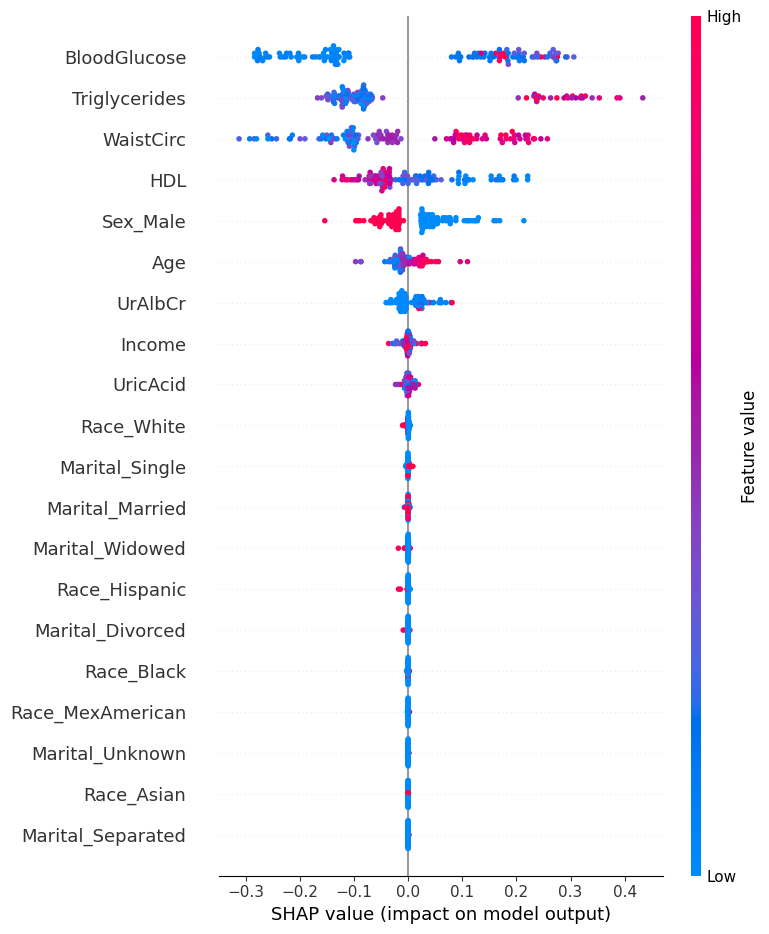

In [36]:
# SHAP Summary Plot (global)
shap.summary_plot(shap_values[..., 1], X_test)

La interpretación de la *feature importance* de SHAP es consistente con los resultados ya vistos en la explicabilidad global. Cada punto representa una predicción cuyo color (un gradiente de rojo a azul) indica lo alto o bajo que es su valor y, cuya posición, muestra la magnitud del valor Shapley para esa predicción. En el eje de las X se encuentran los valores Shapley, que muestran el efecto de la *feature* en hacer que la *raw score* suba o baje. 

Vemos, por ejemplo, que la mayoría de puntos rojos de `WaistCirc` y de `Triglycerides` se encuentran en el lado positivo del eje de las X, lo que significa que valores altos de estos marcadores contribuyen al diagnóstico positivo de síndrome metabólico, esto es, a una alta puntuación cruda. También se aprecia que `Sex_Male`, al ser una variable binaria, no contiene puntos de color violeta y que ser mujer contribuye a aumentar la *raw score*. El punto más a la izquierda de todos, corresponde a una persona con un valor relativamente bajo de la circunferencia de la cintura, que es el que más contribuye a su baja *raw score*.

SHAP es también capaz de generar *Dependence Plots*:

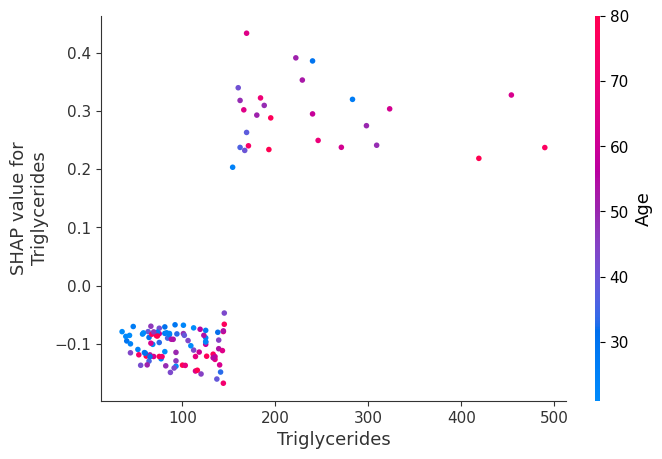

In [37]:
# SHAP Dependence Plot para Triglycerides
shap.dependence_plot('Triglycerides', shap_values[..., 1], X_test)

Vimos un gráfico similar en los PDP, en el que aquí aparece la segunda variable añadiendo color a los puntos. Se aprecia como valores menores a 150 de `Triglycerides` contribuyen a bajar la *raw score* y a partir de ahí la suben, independientemente de la edad, que aparece igualmente representada en ambas zonas, a exepción de los 3 casos extremos.

El mayor potencial de SHAP reside en explicar las predicciones individuales, es decir, la interpretabilidad local. Análogamente al anterior proceso con LIME, tomamos la última observación y recordamos las *raw scores* y el *ground truth* para esa persona. A continuación, llamamos a `force_plot()` que descompone visualmente una sola predicción en las contribuciones positivas y negativas de cada característica.

In [38]:
local_prediction(-1)

Raw score: [0.4 0.6]
Predicción síndrome metabólico del modelo con umbral 0.202: 1 (0.60)
Diagnóstico real: 1


In [40]:
# SHAP Force Plot para la última observación
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.iloc[[-1]])
shap.force_plot(explainer.expected_value[1], shap_values[..., 1], X_test.iloc[[-1]])

Nuestro modelo clasifica como "1" a esta persona y acierta. SHAP indica en qué medida el valor de una variable influye en la predicción de una observación en particular, en comparación con la predicción promedio para el conjunto de datos (*base value*). Por tanto, la puntuación de cada atributo que vemos es la contribución marginal, es decir, cuánto cada característica fuerza a la predicción a alejarse de ese *base value*. Las variables que aumentan la puntuación de la predicción se muestran en rojo, las que lo disminuyen en azul.

Vemos que valores de `BloodGlucose` de 125 y `WaistCirc` de 130,5 son los que más contribuyen al valor de la *raw score*, mientras que un `HDL` de 60 y `Triglycerides` de 135 es lo que más lo reduce. Resultados que estan en consonancia con los que vimos empleando LIME. Sin embargo, SHAP considera `UrAlbCr` más determinante que variables como `Sex` y `Age`.

Esta misma explicación la podemos visualizar de manera distinta llamando al plot `waterfall()` que, en lugar de mostrar ese "tira y afloja" anterior, presenta una acumulación paso a paso del valor Shapley para cada variable:

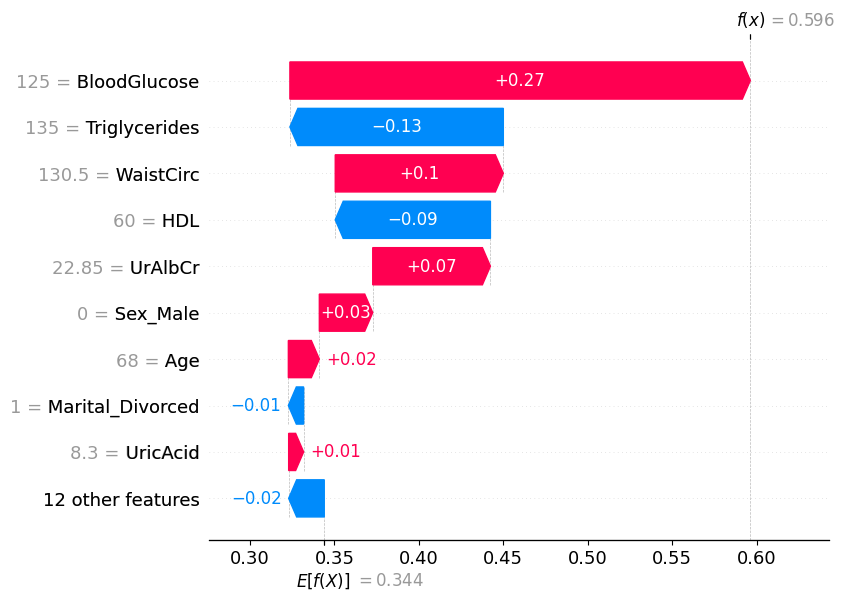

In [41]:
# SHAP Waterfall Plot para la penúltima observación
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[:,:,1][-1])

Aquí vemos el valor base de 0,344 (la media de las *raw scores* del modelo para la clase positiva) y, a cada paso a continuación, como las *features* van ajustando esa puntuación arriba o abajo, hasta alcanzar el *raw score* predicho de ~0,57.

Mostremos, por último, este tipo de gráfico para el Falso Negativo de la predicción del modelo:

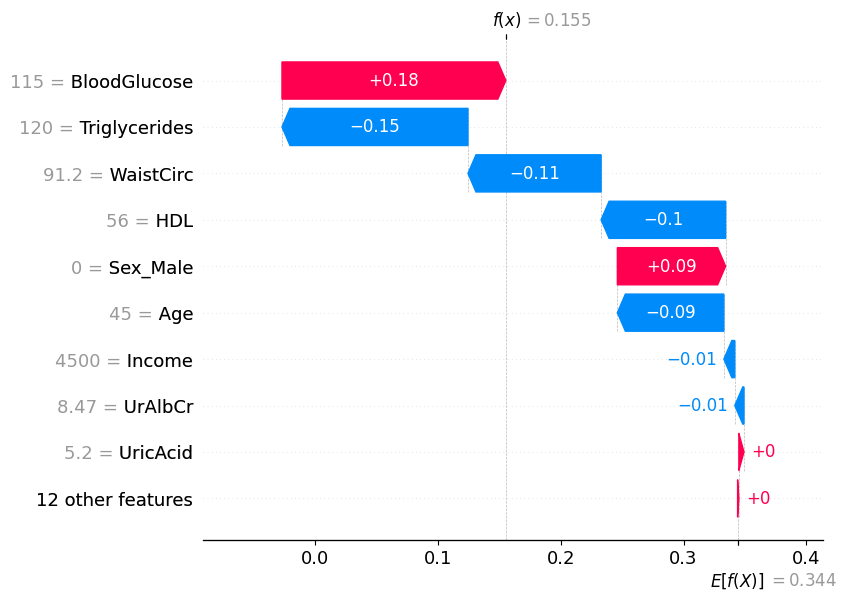

In [42]:
# SHAP Waterfall Plot para la observación 111, aka Falso Negativo
shap.plots.waterfall(shap_values[:,:,1][111])

La paciente 111 se predice como sana y en ello contribuyen principalmente los valores de `Triglycerides` y `HDL`. El único marcador que aporta de manera significativa hacia el diagnóstico de síndrome metabólico es `BloodGlucose` y el hecho que sea mujer. Aunque no es suficiente para cruzar el umbral que diagnosticaría acertadamemte a esta paciente con síndrome metabólico.

## Conclusiones

Las técnicas *post hoc* de explicabilidad que se han aplicado al modelo seleccionado, un *random forest* para la predicción del síndrome metabólico, se han dividido en globales y locales, dependiendo de si el método de interpretación explica todo el comportamiento del modelo o una predicción individual. La mayoría de estas técnicas emplean perturbaciones de los datos (variaciones de los valores de las variables) y analizan las predicciones del modelo para estos cambios.

Para el análisis global se empleó, como primera técnica, la *permutation feature importance*, mostrando que los marcadores relacionados con triglicéridos, la glucosa en sangre y la circunferencia de la cintura son las características más determinantes para el diagnóstico del síndrome metabólico. Esto refuerza las conclusiones extraídas durante el análisis exploratorio de los datos (EDA). Luego, `HDL`, `Sex` y `Age` son también bastante importantes, aunque estas dos últimas no pudimos constatarlas desde la EDA. Algunas de las limitaciones de este método se pudieron complementar con los gráficos de dependencia parcial (PDP) y los de expectactiva condicional individual (ICE), siendo los primeros el promedio de las líneas del segundo. Mostraron las relaciones no lineales que seguían las *features* más importantes como, por ejemplo, la relación en la cual valores superiores a 100 en `BloodGlucose` y a 140 en `Triglycerides` aumentan notablemente las posibilidades de diagnóstico positivo.

Aunque se considera ICE como un método local por mostrar las predicciones individuales, son las siguientes técnicas las que caracterizan esta categoría. LIME y SHAP permitieron descomponer predicciones concretas en contribuciones de las características a la decisión del diagnóstico. SHAP ofrece más versatilidad y una visión más completa al poder mostrar una interpretación global con los *Shapley values*. Gracias a éstos, podemos constatar que, para el modelo, ser mujer es un factor que contribuye al diagnóstico de síndrome metabólico, así como la edad, más de lo que un principio anotabamos. Finalmente, DiCE aportó una interpretación distinta con la generación de explicaciones contrafactuales, que sugieren cómo cambios en las variables podrían alterar el diagnóstico, lo cual puede aportar otro enfoque para la toma de decisiones médicas.

Todas las técnicas utilizadas fueron *model-agnostic*, garantizando su aplicabilidad a otros algoritmos en caso de que se seleccionarán otros modelos. Sin embargo, estas explicaciones ofrecen poca información sobre la incertidumbre y confiabilidad del modelo, algo esencial para la toma de decisiones informada y que consideramos una parte necesaria de una explicación para hacer que el modelo subyacente sea más transparente. Además, en la XAI local, se ha usado la puntuación cruda como un indicador de la probabilidad de cada clase, pero es bien sabido que la mayoría de los modelos de aprendizaje automático suelen estar mal calibrados, lo que significa que las puntuaciones crudas no se corresponden con las probabilidades reales. Trataremos de abordar estas cuestiones en el siguiente cuaderno sobre cuantificación de la incertidumbre (UQ).

## Gráficos extra para incluir en la memoria

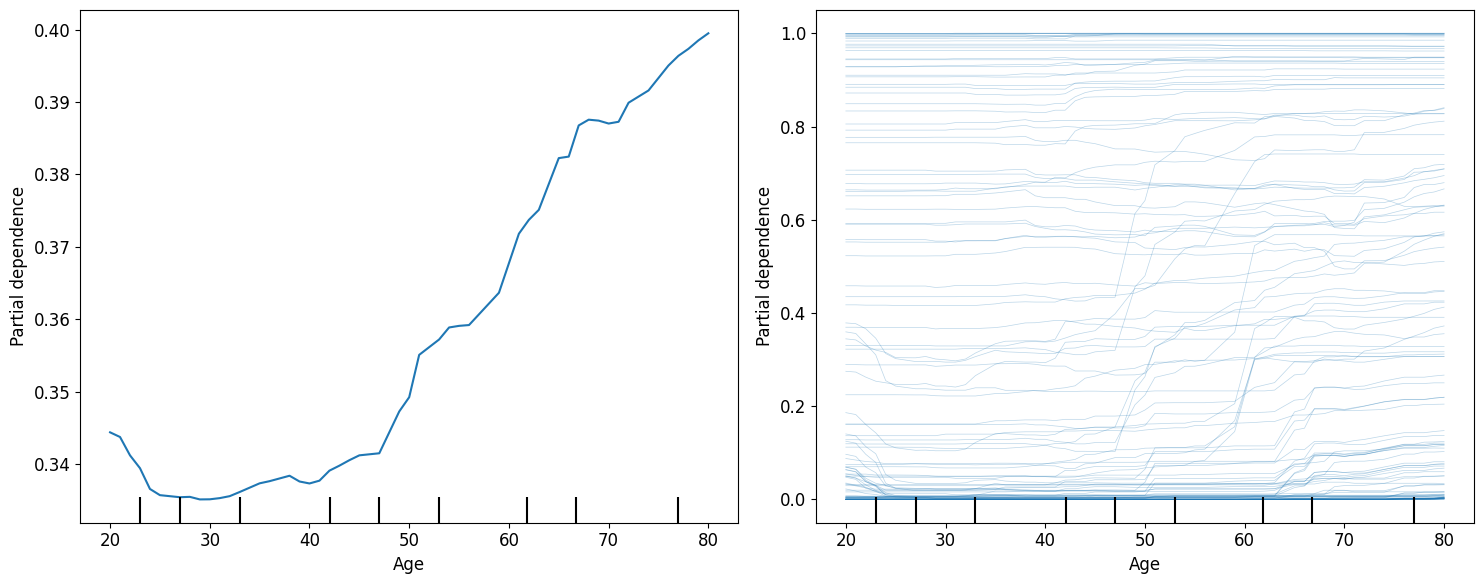

In [43]:
# Generamos un gráfico para poder incluir en la memoria para mostrar el PDP y el ICE de Age
feature = ['Age']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PDP
PartialDependenceDisplay.from_estimator(model, X_test, features=feature, random_state=23, ax=axes[0])

# ICE
PartialDependenceDisplay.from_estimator(model, X_test, features=feature, kind='individual', random_state=23, ax=axes[1])

fig.tight_layout()
plt.show()